# Preguntas
1. ¿Cuantos datos hay en el dataset?
2. ¿Cuantos labels existen?
3. ¿Cuantas imágenes corresponden a cada label?
4. ¿Cuál es la proporción de imágenes que hay entre cada uno de los labels?
5. ¿Las imágenes son todas de igual tamaño?
6. ¿Hay cambios considerables en la imagen si se hace un resize acorde a los input requeridos por efficientNet?

In [26]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile
from glob import glob
import gc
from PIL import Image
from skimage import io, exposure, feature
from skimage.transform import rescale
from skimage.color import rgb2gray
import tifffile
Image.MAX_IMAGE_PIXELS = None

In [27]:
dataset_df = pd.read_csv('train.csv')
print("Cantidad de filas del dataset: {}".format(len(dataset_df.index)))
print("Número de pacientes únicos no repetidos: {}".format(dataset_df['patient_id'].nunique()))
print("Cantidad de etiquetas de clasificación: {}".format(dataset_df['label'].nunique()))
dataset_df.head()

Cantidad de filas del dataset: 754
Número de pacientes únicos no repetidos: 632
Cantidad de etiquetas de clasificación: 2


,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


# Análisis del Dataframe
## Se puede observar que el df cuenta con 5 columnas, detalladas a continuación:
1. image_id: identificador único de la imágen, en una concatenación de la forma {patient_id}_{image_num}
2. center_id: identifica el centro médico de donde fue obtenida la imagen
3. patient_id: Identificador del paciente, es único al paciente pero puede venir varias veces en el dataset, según la cantidad de imágenes por paciente
4. image_num: Enumera las imágenes obtenidas del mismo paciente
5. label: label de clasificación, en dos categorías CE (cardioembólico) y LAA (Arteroesclerosis de grandes arterias)

Cantidad de datos por label: label
CE     547
LAA    207
Name: label, dtype: int64
Proporción de datos: label
CE     72.546419
LAA    27.453581
Name: label, dtype: float64


Text(0, 0.5, 'Cantidad de imágenes')

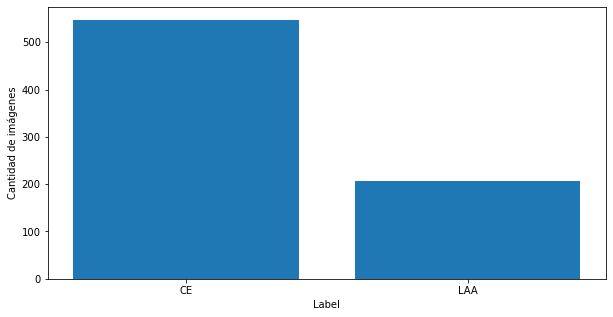

In [28]:
labels = dataset_df.groupby('label')['label']
print("Cantidad de datos por label: {}".format(labels.count()))
proporcion = labels.count()/len(dataset_df)*100
print("Proporción de datos: {}".format(proporcion))
figure = plt.figure(figsize = (10,5))
plt.bar(labels.count().index, labels.count().values)
plt.xlabel("Label")
plt.ylabel("Cantidad de imágenes")

# Ahora a observar las imágenes

## Pacientes con más de una imagen

In [32]:
patients_df = dataset_df.groupby(["patient_id", "label"])["image_num"].count().reset_index(name="images_qty")
patients_df[patients_df["images_qty"]>2].sort_values(by=["images_qty"], ascending=False)

,patient_id,label,images_qty
23,09644e,CE,5
160,3d10be,CE,5
230,56d177,CE,5
364,91b9d3,LAA,5
593,f40c69,LAA,4
202,4f6fb1,CE,4
234,5987c0,CE,4
408,a4c877,CE,4
401,a26055,LAA,3
587,f1f952,CE,3


In [5]:
#Explorar los tamaños de cada una de las imágenes
sizes = []
for image_id in dataset_df["image_id"]:
    #print("train/"+id+".tif")
    img = Image.open("train/"+image_id+".tif")
    sizes.append({"height": img.height,
                  "width" : img.width,
                  "size"  : img.size[0]*img.size[1]/(1024**2)
                 })
dataset_df = pd.concat([pd.DataFrame(sizes), dataset_df], axis=1)
dataset_df.head()

,height,width,size,image_id,center_id,patient_id,image_num,label
0,60797,34007,1971.744136,006388_0,11,006388,0,CE
1,29694,5946,168.381237,008e5c_0,11,008e5c,0,CE
2,61801,15255,899.099593,00c058_0,11,00c058,0,LAA
3,26553,55831,1413.803618,01adc5_0,11,01adc5,0,LAA
4,8267,10533,83.042441,026c97_0,4,026c97,0,CE


In [6]:
dataset_df.describe()

,height,width,size,center_id,image_num
count,754.000000,754.000000,754.000000,754.000000,754.000000
mean,37622.196286,22988.594164,863.434494,7.115385,0.226790
std,18058.750676,15653.642619,721.654858,3.504306,0.599046
min,4470.000000,4417.000000,22.384584,1.000000,0.000000
25%,25402.500000,13215.250000,371.795340,4.000000,0.000000
50%,34981.500000,18700.000000,649.063487,7.000000,0.000000
75%,48919.750000,26376.750000,1124.520066,11.000000,0.000000
max,118076.000000,99699.000000,4669.270031,11.000000,4.000000


## Se puede observar que las dimensiones de las imágenes no son iguales, poseen diferente height,width

In [7]:
def read_image(image_id, dset, scale=None, verbose=1):
    with tifffile.TiffFile("./train/"+image_id+".tif") as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            tif_tags[name] = value
        del tif_tags["TileOffsets"] 
        del tif_tags["TileByteCounts"]
        image = tif.pages[0].asarray()
    if verbose:
       print(f"[{image_id}] Image shape: {image.shape}") 
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
        if image.shape[1]>1.5*image.shape[0]:
            out=cv2.transpose(image)
            image=cv2.flip(out,flipCode=0)  
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")        
    return image, tif_tags

def plot_image(image, image_id):
    plt.figure(figsize=(16, 10))
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)  
    plt.axis('off')
    plt.show()

def plot_list_img(sample_ids, dset, scale=20):
    sample_images = []
    for sample_id in sample_ids:
        sample_images.append(read_image(sample_id, dset, scale=scale, verbose=0)[0])
    plt.figure(figsize=(16, 16))
    for ind, (tmp_id, tmp_image) in enumerate(zip(sample_ids, sample_images)):
        plt.subplot(2, 5, ind + 1)
        plt.imshow(tmp_image)
        plt.title(f"{tmp_id}", fontsize=10) 
        plt.axis("off")

[006388_0] Image shape: (60797, 34007, 3)
[006388_0] Resized Image shape: (30398, 17003, 3)
{'ImageWidth': 34007, 'ImageLength': 60797, 'BitsPerSample': (8, 8, 8), 'Compression': <COMPRESSION.ADOBE_DEFLATE: 8>, 'PhotometricInterpretation': <PHOTOMETRIC.RGB: 2>, 'Orientation': <ORIENTATION.TOPLEFT: 1>, 'SamplesPerPixel': 3, 'XResolution': (10, 1), 'YResolution': (10, 1), 'PlanarConfiguration': <PLANARCONFIG.CONTIG: 1>, 'ResolutionUnit': <RESUNIT.CENTIMETER: 3>, 'Predictor': <PREDICTOR.HORIZONTAL: 2>, 'TileWidth': 128, 'TileLength': 128, 'SampleFormat': (<SAMPLEFORMAT.UINT: 1>, <SAMPLEFORMAT.UINT: 1>, <SAMPLEFORMAT.UINT: 1>)}


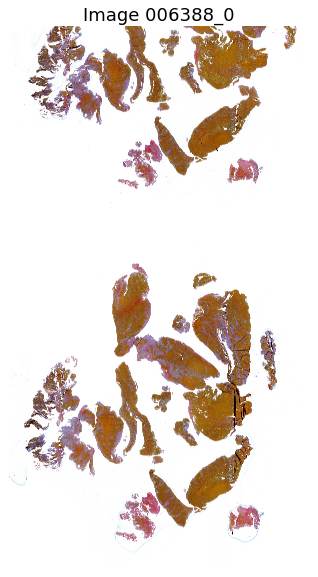

In [8]:
#Tomamos la primera imagen del dataset para visualización
img_id = dataset_df['image_id'][0]
img, tags = read_image(img_id, "train", scale=2)
print(tags)
plot_image(img, img_id)

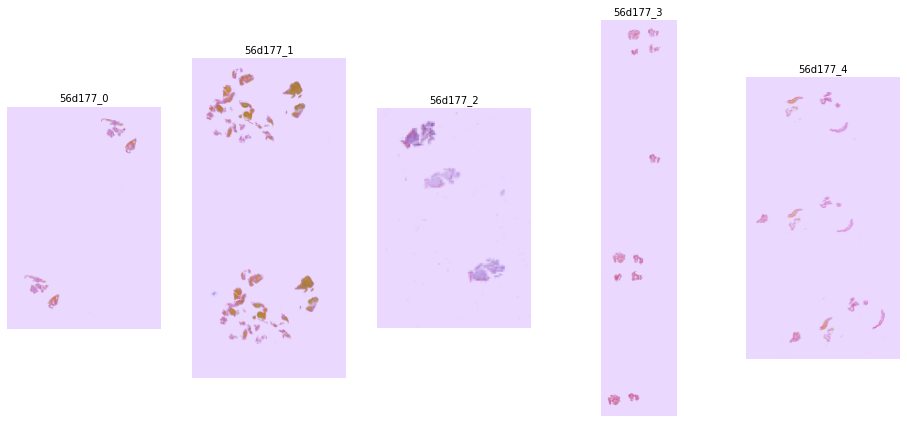

In [9]:
#Ahora ploteamos varias imágenes de un paciente conocido que posee varias muestras
muestras = []
for nro_muestra in range(0,5):
    muestras.append('56d177_{}'.format(nro_muestra))
    
plot_list_img(muestras, "train", scale=100)

In [12]:

def plotImageWithModifications(image_id, size):
    path = "./train/"
    image = tifffile.imread(path+"{}.tif".format(image_id))
    resized_img = cv2.resize(image, (size,size))
    contrasted_img = exposure.adjust_gamma(resized_img, 2)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    edge_img = feature.canny(gray_img, sigma=3)
    ig, ax = plt.subplots(1,4, figsize=(15,30))
    ax[0].imshow(resized_img); ax[0].set_title('Imagen con resize')
    ax[1].imshow(contrasted_img); ax[1].set_title('Incremento de contraste')
    ax[2].imshow(edge_img); ax[2].set_title('Bordes de formas')
    ax[3].imshow(gray_img, cmap='gray'); ax[3].set_title('Escala de grises')
    plt.show()
    
    
    #limpiar memoria
    del image
    del resized_img
    del gray_img
    del edge_img
    del contrasted_img
    gc.collect()
    
    
    

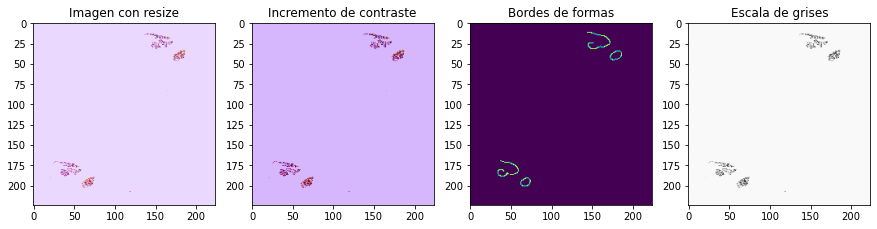

In [13]:
plotImageWithModifications("56d177_0", 224)

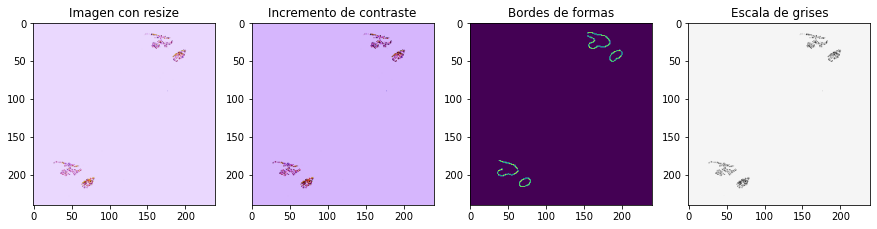

In [17]:
plotImageWithModifications("56d177_0", 240)

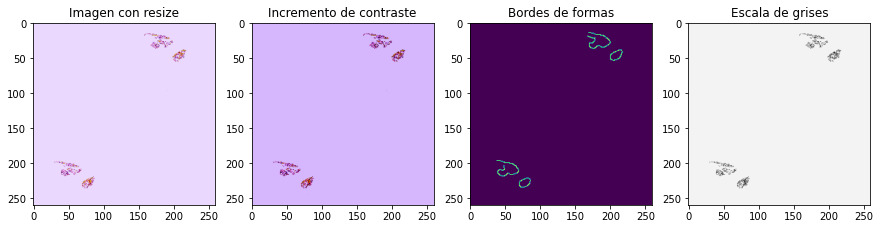

In [18]:
plotImageWithModifications("56d177_0", 260)

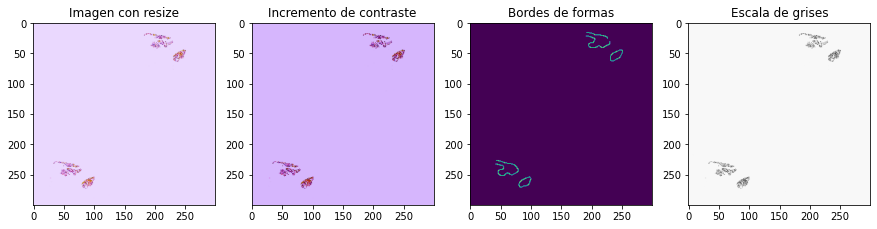

In [19]:
plotImageWithModifications("56d177_0", 300)

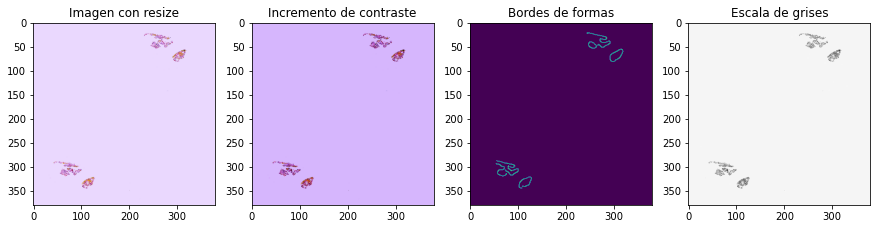

In [20]:
plotImageWithModifications("56d177_0", 380)

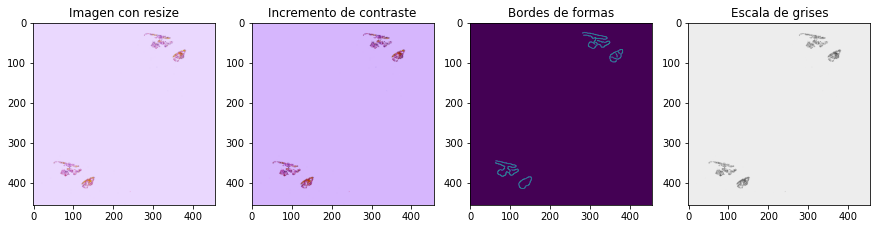

In [21]:
plotImageWithModifications("56d177_0", 456)

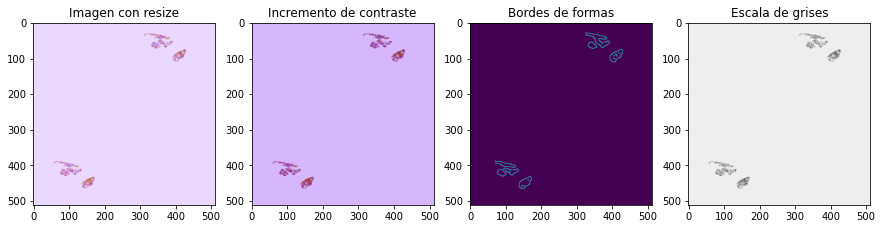

In [22]:
plotImageWithModifications("56d177_0", 512)

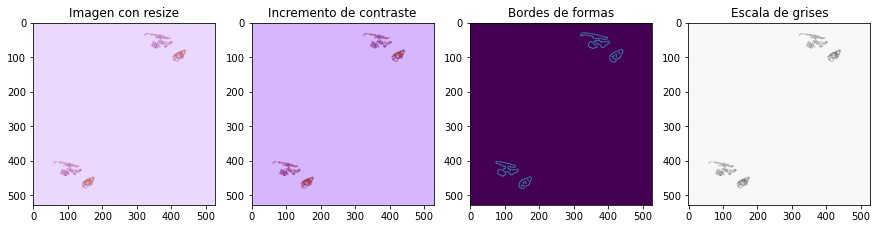

In [24]:
plotImageWithModifications("56d177_0", 528)

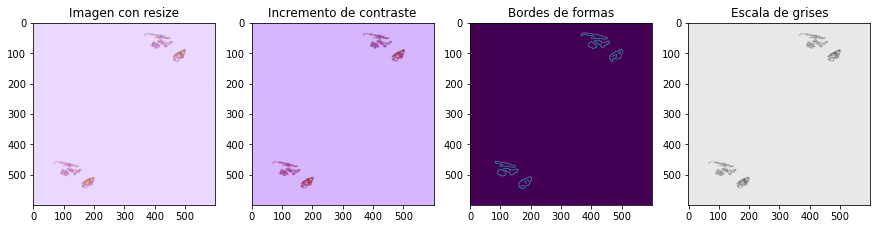

In [25]:
plotImageWithModifications("56d177_0", 600)